In [1]:
from pathlib import Path

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
pd.set_option('display.max_rows', 4)

## Parameters

In [4]:
#parameters
tmp_data_path = "../tmp_data/"

## Read log files

In [5]:
host_logs = pd.read_parquet("../tmp_data/host_logs.prq")

In [6]:
host_logs

,Date,Free_CPUs,Free_Mem1,Used_CPUs,Cpu,Used_Mem1,ExecutionHost,QueueName,Free_Swap1,Used_Swap1,Load
0,2020-01-12 18:17:31,0,349.402344,32,32.0,33.308594,neshcl218,clbigmem,NaN,NaN,NaN
1,2020-01-12 18:17:31,0,302.101562,32,32.0,80.609375,neshcl219,clbigmem,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2206619,2020-04-07 09:53:57,63,736.996094,1,0.0,29.714844,nesh-fe2-adm,nan,0.085938,3.910156,0.4
2206620,2020-04-07 09:53:57,63,752.734375,1,1.0,13.976562,nesh-fe3-adm,nan,1.750000,2.246094,1.0


## Set index

In [7]:
host_logs = host_logs.set_index("Date")

## Login nodes

**FIXME:** The following now un-necessarily and wronly swaps free and used mem.

In [8]:
def plot_for_these_login_nodes(login_nodes, variable, ylabel):
    print('\n'+ylabel)
    for login_node in login_nodes:
        this_node = host_logs["ExecutionHost"].str.contains('nesh-'+login_node+'-adm')
        time_series = host_logs[this_node][variable].resample('6h').mean()
        time_series.plot(label=login_node)
        plt.legend(); plt.grid(); plt.ylabel(ylabel)
        quantile = time_series.quantile([0.05, 0.50, 0.95])
        print("{}: {:4.2f} {:4.2f} {:4.2f}".format(
            login_node, quantile[0.05], quantile[0.50], quantile[0.95])
             )

def plot_for_login_nodes(variable, ylabel):
    plot_for_these_login_nodes(['fe1', 'fe2', 'fe3'], variable, ylabel)


Memory utilization in GB
fe1: 14.21 20.16 177.65
fe2: 14.54 29.19 294.93
fe3: 14.33 24.68 194.31


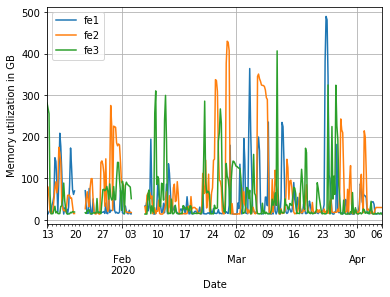

In [9]:
plt.figure(); plot_for_login_nodes("Used_Mem1", 'Memory utilization in GB')


Occupied CPUs
fe1: 0.36 2.78 10.35
fe2: 0.08 2.11 17.39
fe3: 0.83 4.22 12.03

CPU utilization
fe1: 0.13 2.29 9.74
fe2: 0.01 1.51 16.61
fe3: 0.16 3.87 11.41

Load average
fe1: 0.31 4.53 24.90
fe2: 0.05 2.63 21.36
fe3: 0.45 7.82 24.91


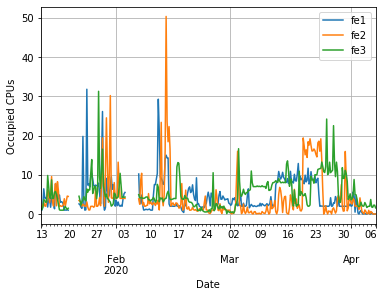

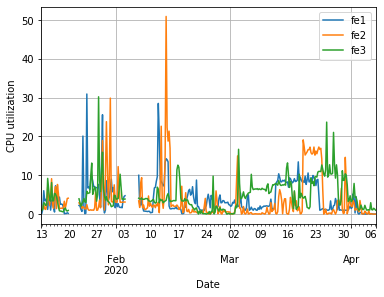

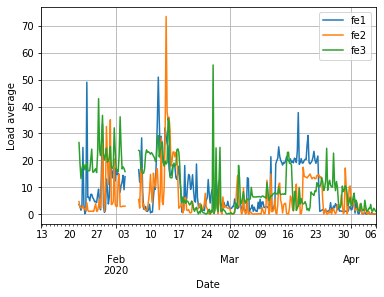

In [10]:
plt.figure(); plot_for_login_nodes("Used_CPUs", "Occupied CPUs")
plt.figure(); plot_for_login_nodes("Cpu", "CPU utilization")
plt.figure(); plot_for_login_nodes("Load", "Load average")

## Login and feque batch node
This is a hybrid node that can be accessed both via SSH and with batch job tasks.


Memory utilization in GB
fe0: 14.90 19.24 125.95


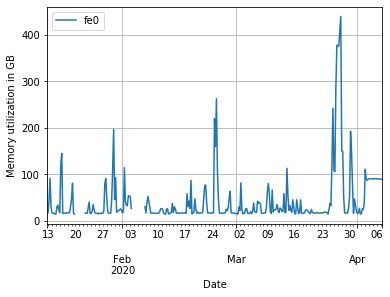

In [11]:
plt.figure(); plot_for_these_login_nodes(['fe0'], "Used_Mem1",
                                         'Memory utilization in GB')


Occupied CPUs
fe0: 0.00 0.97 6.20

CPU utilization
fe0: 0.00 0.32 5.69

Load average
fe0: 0.04 1.23 15.88


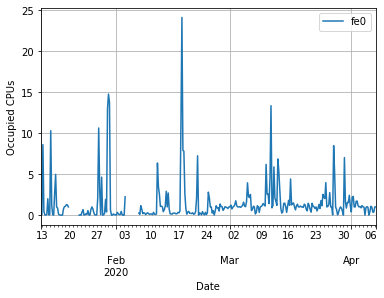

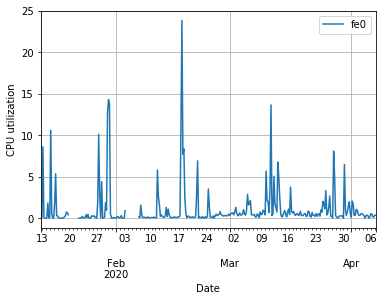

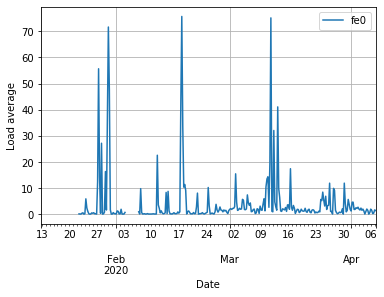

In [12]:
plt.figure(); plot_for_these_login_nodes(["fe0"], "Used_CPUs", "Occupied CPUs")
plt.figure(); plot_for_these_login_nodes(["fe0"], "Cpu", "CPU utilization")
plt.figure(); plot_for_these_login_nodes(["fe0"], "Load", "Load average")

## Batch production nodes
Nodes in the `clexpress`, `clmedium` and `cllong` batch classes have the same hardware configuration, i.e. the same type of CPUs and memory sizes. Nodes in the `clbigmem` batch class have larger memory size, and compute nodes in the `clfo2` batch class have other CPU types and memory sizes.

In [13]:
def plot_for_batch_nodes(these_nodes, this_queue):
    
    tbox = dict(facecolor='white', alpha=0.75, edgecolor='white')

    # Calculate meta information. (Without consistency checks.)
    
    total_host_number = these_nodes['ExecutionHost'].unique().size
    base_cpu_number = (these_nodes['Free_CPUs'].astype('int') +
                       these_nodes['Used_CPUs'].astype('int')).mean()
    base_memory_size = (these_nodes['Free_Mem1'].astype('int') +
                        these_nodes['Used_Mem1'].astype('int')).mean()
    
    # Define conversions for secondary axis object.
    # https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/secondary_axis.html
    
    def abs2rel_cpu(abs_number):
        return (100*abs_number/base_cpu_number)/total_host_number
    def rel2abs_cpu(rel_number):
        return (rel_number/100*base_cpu_number)*total_host_number
    def abs2rel_mem(abs_number):
        return (100*abs_number/base_memory_size)/total_host_number
    def rel2abs_mem(rel_number):
        return (rel_number/100*base_memory_size)*total_host_number

    # Plot CPU stuff.
    
    plt.figure()
    time_series = 100*these_nodes['Used_CPUs'].resample('1h').mean()/base_cpu_number
    ax = time_series.plot()
    plt.hlines(time_series.median(), these_nodes.index[0], these_nodes.index[-1], 'm')
    t = plt.text(0.1,0.1,'median: {:3.1f}% or {:4.0f} CPUs'.format(time_series.median(), rel2abs_cpu(time_series.median())), transform=ax.transAxes, color='m')
    t.set_bbox(tbox)
    plt.ylabel('occupied CPUs in %\n'+str(total_host_number)+' execution host average')
    plt.title(this_queue+': '+str(base_cpu_number)+' CPUs per execution host')
    
    secaxy = ax.secondary_yaxis('right',functions=(rel2abs_cpu, abs2rel_cpu))
    secaxy.set_ylabel('total number of occupied CPUs\nfor '+this_queue+' batch class')
    plt.grid()
    
    # Plot more CPU stuff.
    
    plt.figure()
    time_series = 100*these_nodes['Cpu'].resample('1h').mean()/base_cpu_number
    ax = time_series.plot()
    plt.hlines(time_series.median(), these_nodes.index[0], these_nodes.index[-1], 'm')
    t = plt.text(0.1,0.1,'median: {:3.1f}% or {:4.0f} CPUs'.format(time_series.median(), rel2abs_cpu(time_series.median())), transform=ax.transAxes, color='m')
    t.set_bbox(tbox)
    plt.ylabel('utilized CPUs in %\n'+str(total_host_number)+' execution host average')
    plt.title(this_queue+': '+str(base_cpu_number)+' CPUs per execution host')
    
    secaxy = ax.secondary_yaxis('right',functions=(rel2abs_cpu, abs2rel_cpu))
    secaxy.set_ylabel('total number of utilized CPUs\nfor '+this_queue+' batch class')
    plt.grid()
    
    # Plot load average stuff.
    
    plt.figure()
    time_series = these_nodes['Load'].resample('1h').mean()/base_cpu_number
    ax = time_series.plot()
    plt.hlines(time_series.median(), these_nodes.index[0], these_nodes.index[-1], 'm')
    t = plt.text(0.1,0.1,'median: {:3.1f}'.format(time_series.median()), transform=ax.transAxes, color='m')
    t.set_bbox(tbox)
    plt.ylabel('normalized load average\n'+str(total_host_number)+' execution host average')
    plt.title(this_queue+': '+str(base_cpu_number)+' CPUs per execution host')
    plt.grid()
    
    # Plot memory stuff.
    
    plt.figure()
    time_series = 100*these_nodes['Used_Mem1'].resample('3h').mean()/base_memory_size
    ax = time_series.plot()
    plt.hlines(time_series.median(), these_nodes.index[0], these_nodes.index[-1], 'm')
    t = plt.text(0.1,0.1,'median: {:3.1f}% or {:4.1f} GB'.format(time_series.median(),rel2abs_mem(time_series.median())), transform=ax.transAxes, color='m')
    t.set_bbox(tbox)
    plt.ylabel('utilized memory in %\n'+str(total_host_number)+' execution host average')
    plt.title('{}: {:4.1f} GB per execution host '.format(this_queue, base_memory_size))
    secaxy = ax.secondary_yaxis('right',functions=(rel2abs_mem,abs2rel_mem))
    secaxy.set_ylabel('total utilized memory in GB\nfor '+this_queue+' batch class')
    plt.grid()
    

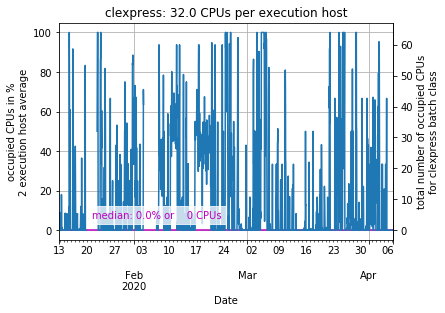

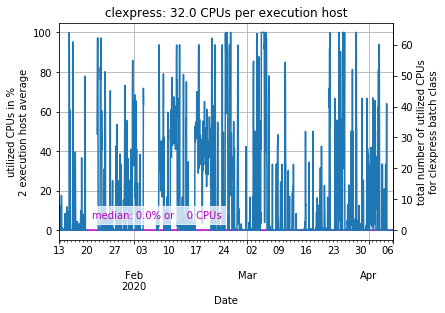

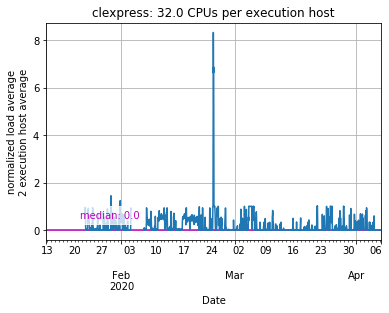

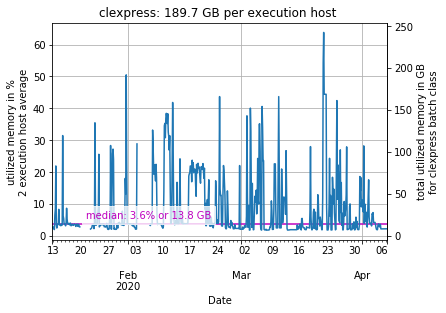

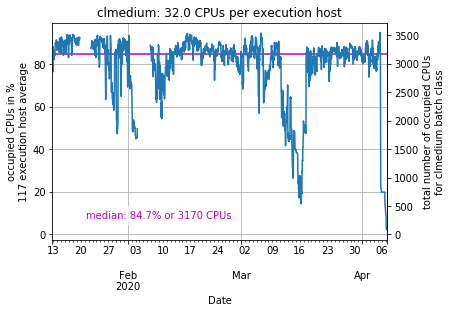

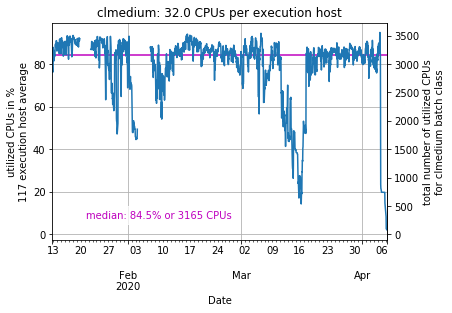

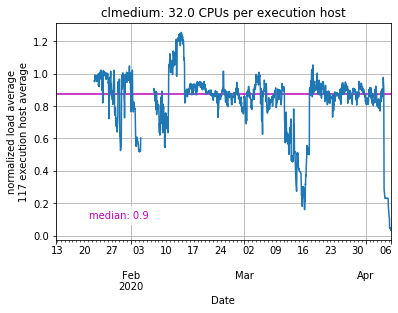

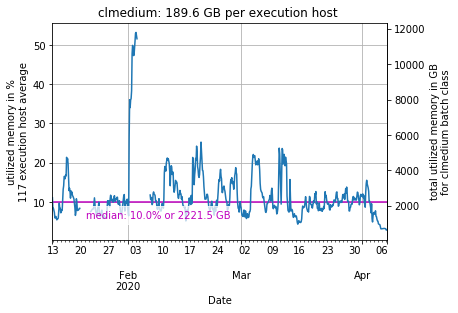

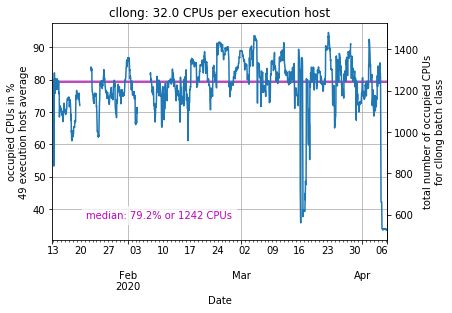

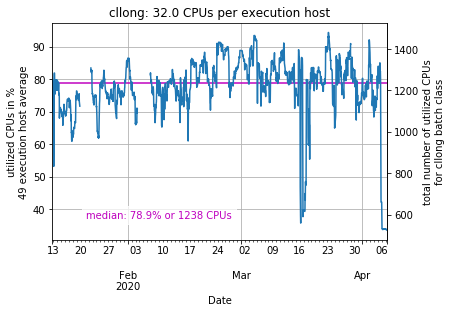

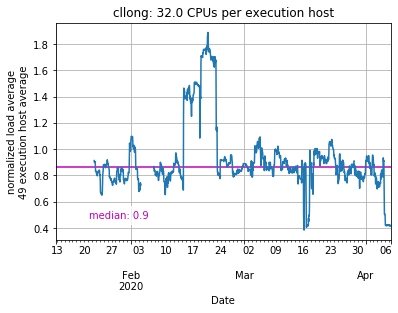

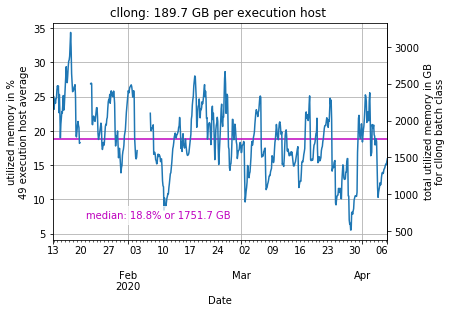

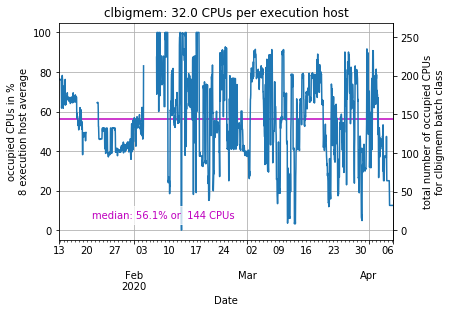

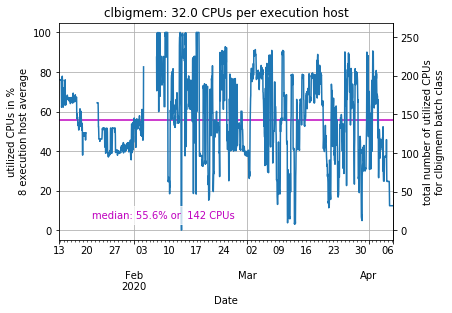

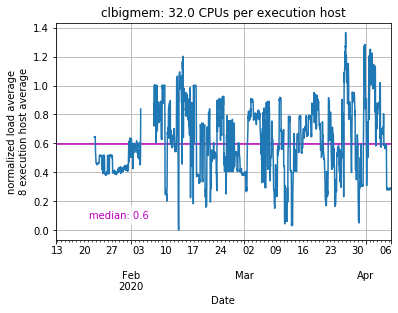

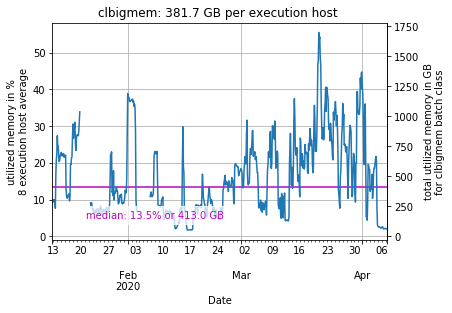

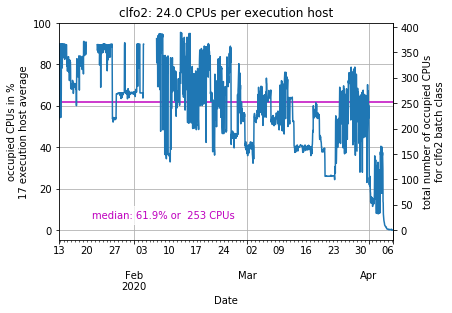

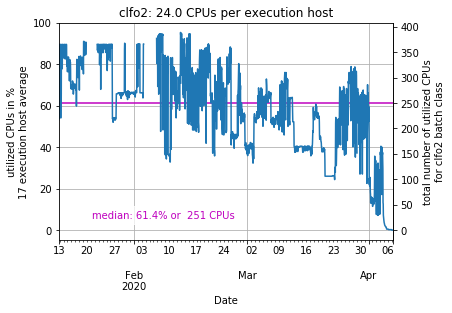

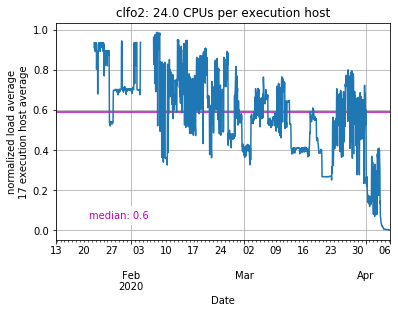

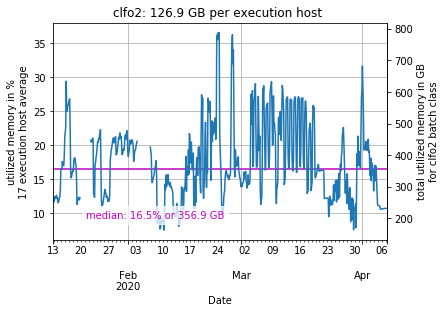

In [14]:
for this_batch_class in ['clexpress', 'clmedium', 'cllong', 'clbigmem', 'clfo2']:
    these_nodes = host_logs["QueueName"].str.contains(this_batch_class)
    plot_for_batch_nodes(host_logs[these_nodes], this_batch_class)

Now, estimate utilization for identical CPU type execution hosts.

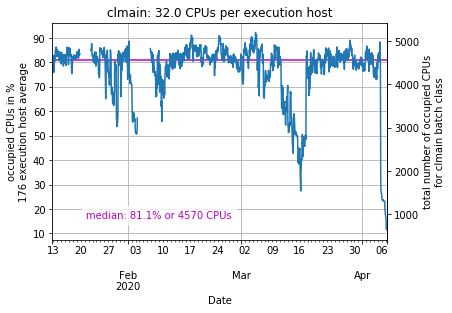

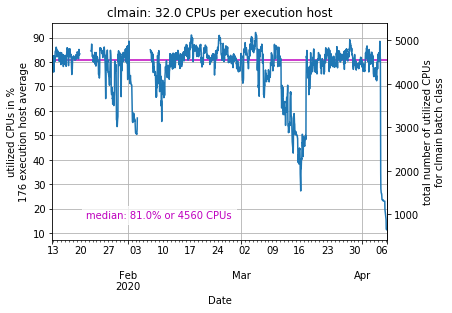

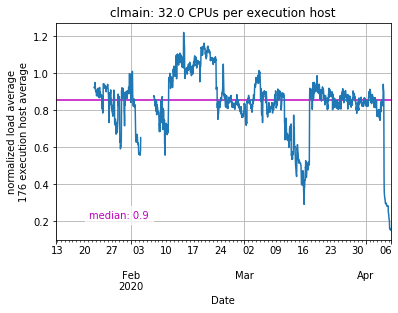

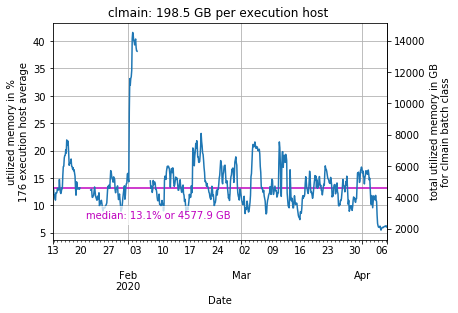

In [15]:
these_batch_classes = 'clexpress|clmedium|cllong|clbigmem'
these_nodes = host_logs["QueueName"].str.contains(these_batch_classes)
plot_for_batch_nodes(host_logs[these_nodes], 'clmain')

## Add example histograms...

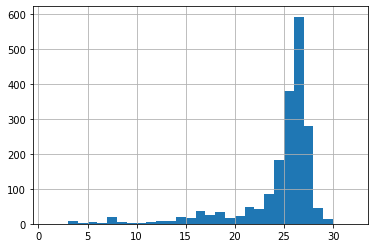

In [16]:
these_batch_classes = 'clexpress|clmedium|cllong|clbigmem'
these_nodes = host_logs["QueueName"].str.contains(these_batch_classes)
host_logs[these_nodes]["Used_CPUs"].resample('1h').mean().hist(bins=np.arange(1,33,1))

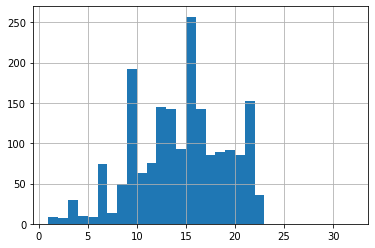

In [17]:
these_nodes = host_logs["QueueName"].str.contains('clfo2')
host_logs[these_nodes]["Used_CPUs"].resample('1h').mean().hist(bins=np.arange(1,33,1))

# Python environment

In [18]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: osx-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/osx-64/tbb-2018.0.5-h2d50403_0.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/blas-1.0-mkl.conda
https://conda.anaconda.org/conda-forge/osx-64/ca-certificates-2019.11.28-hecc5488_0.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/intel-openmp-2019.4-233.conda
https://repo.anaconda.com/pkgs/main/osx-64/jpeg-9b-he5867d9_2.conda
https://repo.anaconda.com/pkgs/main/osx-64/libcxxabi-4.0.1-hcfea43d_1.conda
https://repo.anaconda.com/pkgs/main/osx-64/libgfortran-3.0.1-h93005f0_2.conda
https://repo.anaconda.com/pkgs/main/osx-64/libsodium-1.0.16-h3efe00b_0.conda
https://repo.anaconda.com/pkgs/main/osx-64/pandoc-2.2.3.2-0.conda
https://repo.anaconda.com/pkgs/main/osx-64/xz-5.2.4-h1de35cc_4.conda
https://repo.anaconda.com/pkgs/main/osx-64/yaml-0.1.7-hc338f04_2.conda
https://repo.anaconda.com/pkgs/main/osx-64/zlib-1.2.11-h